# The effect of volatility on a 60/40 portfolio

[Earlier](60-40-volatility-normal.ipynb), we had used a normal distribution to project future returns to get an idea of the impact of volatility on total returns. Here, we use a Generalised Lambda Distribution to model the distribution of returns instead.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
library(gld)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

indices <- Indices()

In [27]:
startDate <- as.Date('1999-01-01')
endDate <- as.Date('2019-12-15')

eqIndex1 <- "NIFTY 50 TR" 
timeRanges <- c("2001/2010", "2011/2020")
lookback <- 5*12 #months

In [28]:
eqDt1 <- indices$NseTimeSeries() %>%
    filter(NAME == eqIndex1 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(TIME_STAMP, CLOSE) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqXts1 <- Common.NormalizeMonthlyDates(monthlyReturn(xts(eqDt1$CLOSE, eqDt1$TIME_STAMP)))
eqXts1 <- eqXts1[-1]
eqXts1 <- eqXts1[-nrow(eqXts1)]

In [29]:
numMonths <- 20*12 #20 years
numIters <- 10000
dateSeq <- seq(from=as.Date("2000-01-20"), by="month", length.out=numMonths)
monthlyBndRet <- 0.05/12 #assume annual bond returns are between 5-6%
bndXts <- xts(rep(monthlyBndRet, numMonths), dateSeq)

seriesFit1<-fit.fkml(coredata(eqXts1[timeRanges[1]]))
seriesFit2<-fit.fkml(coredata(eqXts1[timeRanges[2]]))

series1.lambda1<-as.numeric(seriesFit1$lambda[1])
series1.lambda2<-as.numeric(seriesFit1$lambda[2])
series1.lambda3<-as.numeric(seriesFit1$lambda[3])
series1.lambda4<-as.numeric(seriesFit1$lambda[4])

series2.lambda1<-as.numeric(seriesFit2$lambda[1])
series2.lambda2<-as.numeric(seriesFit2$lambda[2])
series2.lambda3<-as.numeric(seriesFit2$lambda[3])
series2.lambda4<-as.numeric(seriesFit2$lambda[4])

rndSamp1<-rgl(numMonths*numIters,  lambda1 = series1.lambda1, lambda2 = series1.lambda2, lambda3 = series1.lambda3, lambda4 = series1.lambda4)
rndSamp2<-rgl(numMonths*numIters,  lambda1 = series2.lambda1, lambda2 = series2.lambda2, lambda3 = series2.lambda3, lambda4 = series2.lambda4)

In [30]:
simRets <- data.frame(I=-1, RET_EQ=-99.99, RET_60=-99.99)
for(numIter in 1:numIters){
    i1<-numMonths*(numIter-1)+1
    i2<-numMonths*numIter
    
    rndMonthlyRet1 <- rndSamp1[i1:i2]
    retXts1 <- xts(rndMonthlyRet1, dateSeq)
    ret60Xts1 <- 0.6*retXts1 + 0.4*bndXts
    annRet1 <- as.numeric(Return.annualized(retXts1))
    ann60Ret1 <- as.numeric(Return.annualized(ret60Xts1))
    
    rndMonthlyRet2 <- rndSamp2[i1:i2]
    retXts2 <- xts(rndMonthlyRet2, dateSeq)
    ret60Xts2 <- 0.6*retXts2 + 0.4*bndXts
    annRet2 <- as.numeric(Return.annualized(retXts2))
    ann60Ret2 <- as.numeric(Return.annualized(ret60Xts2))

    simRets <- rbind(simRets, c(1, 100.0*annRet1, 100.0*ann60Ret1))
    simRets <- rbind(simRets, c(2, 100.0*annRet2, 100.0*ann60Ret2))
}

simRets <- simRets[-1,]

In [31]:
for(i in 1:2){
    print(sprintf("********* %d **********", i))
    print(summary(simRets[simRets$I==i, ]$RET_EQ))
    print("----------------------------------------------------")
    print(summary(simRets[simRets$I==i,]$RET_60))
}

[1] "********* 1 **********"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -12.86   14.70   19.70   19.88   25.01   52.61       2 
[1] "----------------------------------------------------"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -3.474  11.898  14.747  14.804  17.723  32.595 
[1] "********* 2 **********"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -3.927   6.662   9.155   9.209  11.692  23.478 
[1] "----------------------------------------------------"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.1608  6.3364  7.8193  7.8399  9.3241 16.1380 


In [32]:
summMeans <- simRets %>%
                group_by(I) %>%
                summarize(RET_EQ = median(RET_EQ, na.rm=T), RET_60 = median(RET_60, na.rm=T)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='MEDIAN') %>%
                as.data.frame()

summMin <- simRets %>%
                group_by(I) %>%
                summarize(RET_EQ = min(RET_EQ, na.rm=T), RET_60 = min(RET_60, na.rm=T)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='MIN') %>%
                as.data.frame()

summSdP <- simRets %>%
                group_by(I) %>%
                summarize(RET_EQ = mean(RET_EQ, na.rm=T) + sd(RET_EQ, na.rm=T), RET_60 = mean(RET_60, na.rm=T) + sd(RET_60, na.rm=T)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='SDP') %>%
                as.data.frame()

summSdM <- simRets %>%
                group_by(I) %>%
                summarize(RET_EQ = mean(RET_EQ, na.rm=T) - sd(RET_EQ, na.rm=T), RET_60 = mean(RET_60, na.rm=T) - sd(RET_60, na.rm=T)) %>%
                select(I, RET_EQ, RET_60) %>%
                mutate(X='SDM') %>%
                as.data.frame()

summs <- rbind(summMeans, summMin, summSdP, summSdM)

In [33]:
print(summs)

  I     RET_EQ     RET_60      X
1 1  19.703321 14.7466674 MEDIAN
2 2   9.154873  7.8193202 MEDIAN
3 1 -12.855214 -3.4737768    MIN
4 2  -3.927478 -0.1607505    MIN
5 1  27.489710 19.0942352    SDP
6 2  12.936095 10.0496152    SDP
7 1  12.262197 10.5130631    SDM
8 2   5.481524  5.6301837    SDM


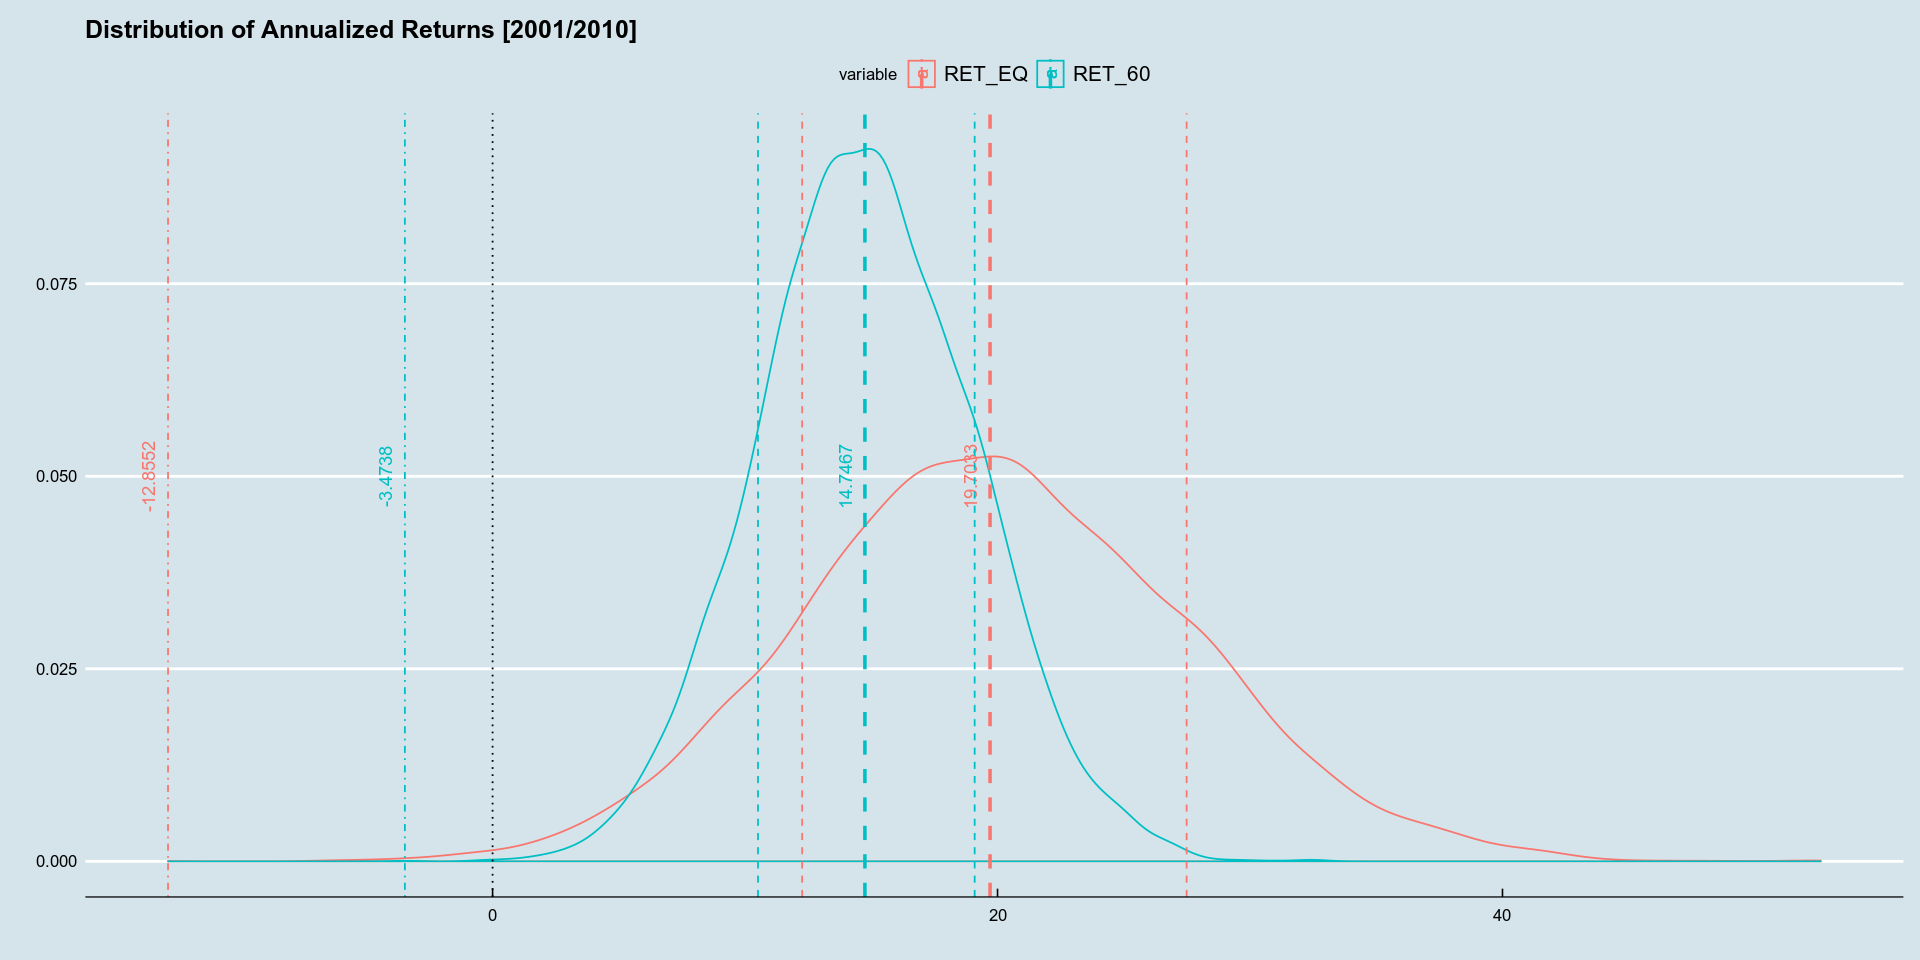

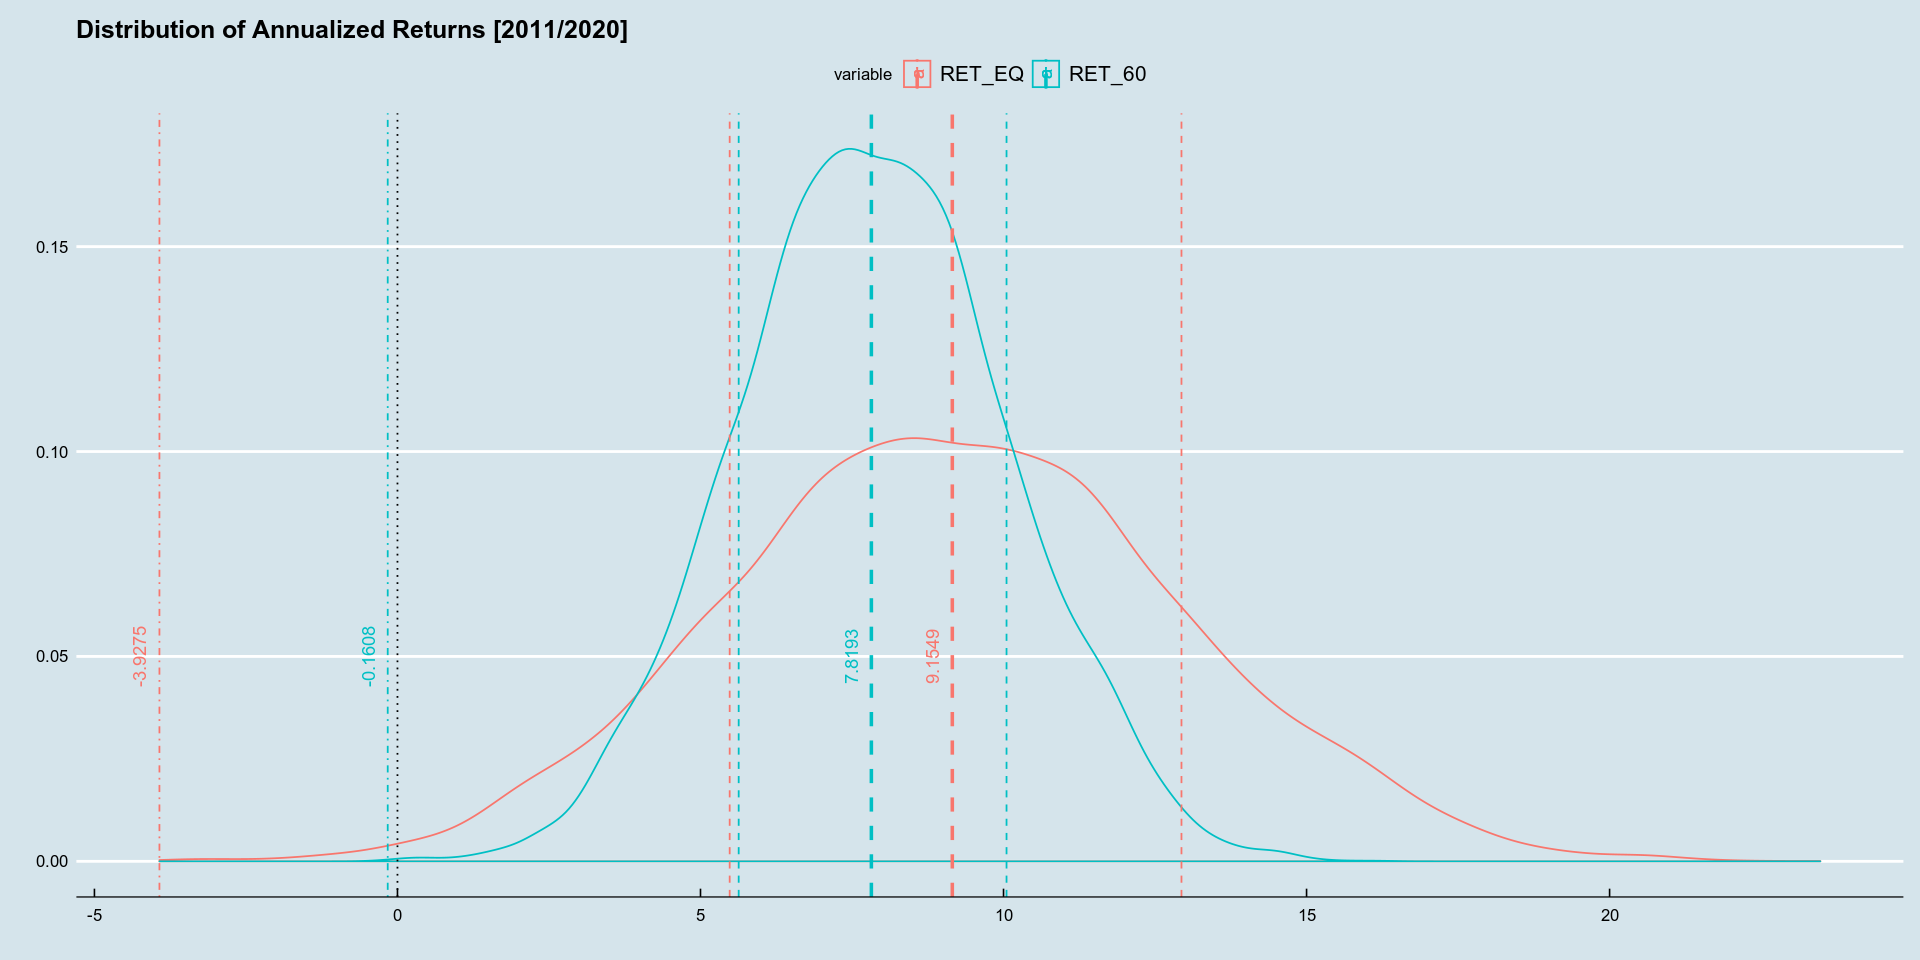

In [34]:
for(i in 1:2){
    plotDf <- simRets[simRets$I == i, c('RET_EQ', 'RET_60')]
    mainTitle <- sprintf("Distribution of Annualized Returns [%s]", timeRanges[i])
    plotgg <- ggplot(melt(plotDf), aes(x=value, color=variable)) +
            theme_economist() +
            geom_density() +
            labs(x='', y='', fill='', line='', title=mainTitle) +
            geom_vline(aes(xintercept=0), linetype='dotted', color='black') +
            geom_vline(data = melt(summs[summs$I == i & summs$X == 'MEDIAN', c('X', 'RET_EQ', 'RET_60')], id='X'), 
                       aes(xintercept=value, color=variable), linetype="dashed", size=1) +
            geom_text(data = melt(summs[summs$I == i & summs$X == 'MEDIAN', c('X', 'RET_EQ', 'RET_60')], id='X'),
                      aes(x=value, label=sprintf("%.4f", value), y=0.05, colour=variable), angle=90, vjust = -1) +
            geom_vline(data = melt(summs[summs$I == i & (summs$X == 'SDP' | summs$X == 'SDM'), c('X', 'RET_EQ', 'RET_60')], id='X'), 
                       aes(xintercept=value, color=variable), linetype="dashed", size=0.5) +
            geom_vline(data = melt(summs[summs$I == i & summs$X == 'MIN', c('X', 'RET_EQ', 'RET_60')], id='X'), 
                       aes(xintercept=value, color=variable), linetype="dotdash", size=0.5) +
            geom_text(data = melt(summs[summs$I == i & summs$X == 'MIN', c('X', 'RET_EQ', 'RET_60')], id='X'),
                      aes(x=value, label=sprintf("%.4f", value), y=0.05, colour=variable), angle=90, vjust = -1)

    print(plotgg)
}

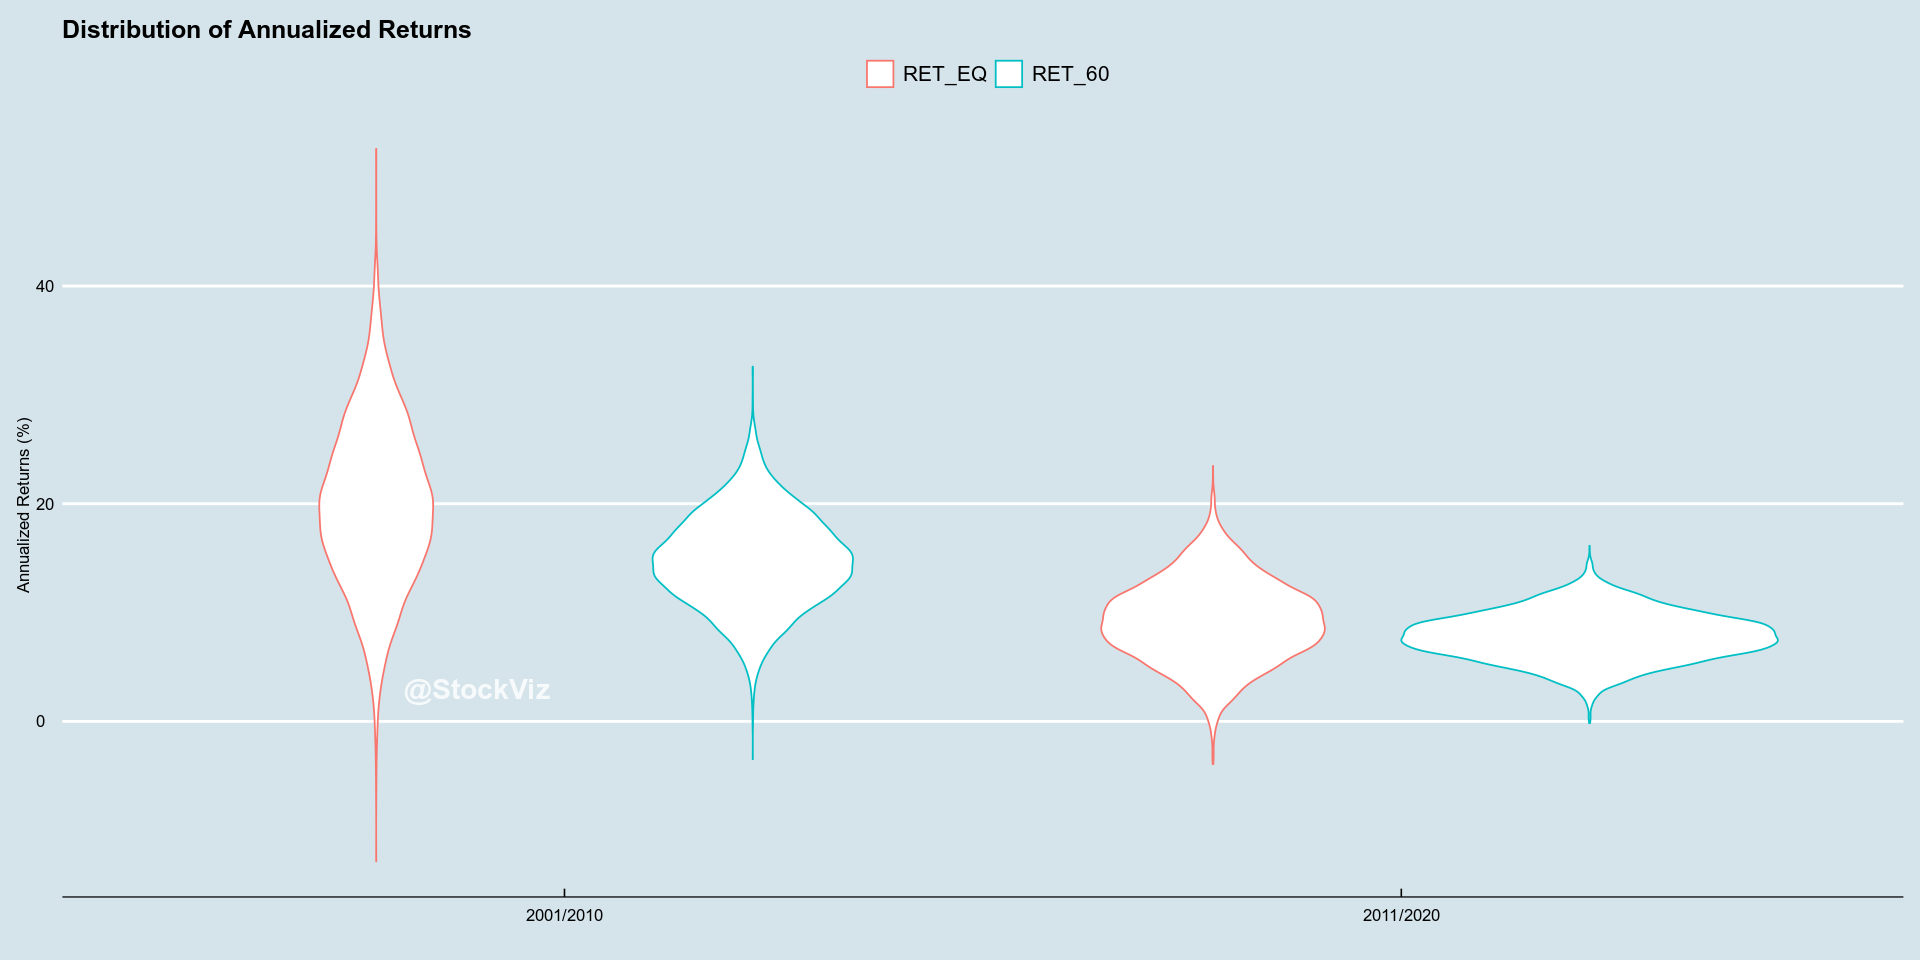

In [35]:
sliceDf <- data.frame(X=timeRanges[simRets$I], RET_EQ=simRets$RET_EQ, RET_60=simRets$RET_60)
sliceDf$X <- factor(sliceDf$X, levels=unique(sliceDf$X))
aggPlotDf <- melt(sliceDf, id='X')

ggplot(aggPlotDf, aes(x=X, y=value, color=variable)) + 
    theme_economist() +
    geom_violin() +
    labs(x='', y='Annualized Returns (%)', fill='', color='',
         title="Distribution of Annualized Returns") +
    annotate("text", x=1, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!